In [1]:
#Import dependencies
import os
import pandas as pd
import numpy as np
import scipy.misc
import tensorflow as tf
import time
from matplotlib.pyplot import imshow
from PIL import Image
from skimage.transform import resize
import imageio as im
%matplotlib inline

import matplotlib.pyplot as plt
import gc



In [2]:
# Run length encoding and decoding
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [3]:
#samples
samples = 10

#Get train images with only ships
masks = pd.read_csv('train_ship_segmentations_v2.csv')
train = masks.dropna()
del train['EncodedPixels']

train_img_files = train.sample(samples)
train_img_files = train_img_files.to_dict('ImageId')

#train_sample = train_img_list.sample(10)
preds = pd.DataFrame.from_csv('submissionv4_1.csv')
ship_images = preds[(preds['exist_ship'] == 1)]
test_img_files = ship_images.to_dict('ImageId')



/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  del sys.path[0]


In [4]:
#Get train images with 50/50 split ships / no ships
'''
train_v2 = os.listdir('./train')
masks = pd.read_csv('train_ship_segmentations_v2.csv')
masks.head()
train = masks
train['exist_ship'] = train['EncodedPixels'].fillna(0)
train.loc[train['exist_ship']!=0, 'exist_ship']=1
del train['EncodedPixels']
train_gp = train.groupby('ImageId').sum().reset_index()
train_gp.loc[train_gp['exist_ship']>0,'exist_ship']=1
train_gp= train_gp.sort_values(by='exist_ship')
train_gp = train_gp.drop(train_gp.index[0:100000])
train_sample = train_gp.sample(1000)
'''

"\ntrain_v2 = os.listdir('./train')\nmasks = pd.read_csv('train_ship_segmentations_v2.csv')\nmasks.head()\ntrain = masks\ntrain['exist_ship'] = train['EncodedPixels'].fillna(0)\ntrain.loc[train['exist_ship']!=0, 'exist_ship']=1\ndel train['EncodedPixels']\ntrain_gp = train.groupby('ImageId').sum().reset_index()\ntrain_gp.loc[train_gp['exist_ship']>0,'exist_ship']=1\ntrain_gp= train_gp.sort_values(by='exist_ship')\ntrain_gp = train_gp.drop(train_gp.index[0:100000])\ntrain_sample = train_gp.sample(1000)\n"

In [6]:
#Helper functions
class Util(object):
    
    @staticmethod
    def read_images(root, files):
        """
        Read in training images

        Args:
            relative path

        Returns
            train_X: dictionary of image_name -> image
        """
        c = 0
        train_X = {}
        for i in files:
            sub_item_name = files[i]['ImageId']
            img_root = root + "/"
            fileName = img_root + sub_item_name
            image = im.imread(fileName)
            train_X[sub_item_name] = image
            c += 1
            if c == samples:
                break
        return train_X
    
    def show_image(image):
        resh = np.reshape(image,(image.shape[0],image.shape[1]))
        tout = (np.array(resh) > 0.4).astype(np.uint8)
        imshow(Image.fromarray(tout))
    
    
    def normalize_images(raw_images, height, width, channels):
        """
        Resize images to the given dimension

        Args:
            raw_images: dictiomary of image_name ->image
            height: height of the resized images
            width: width of the resized images
            channels: number of channels in the resized image

        Returns
            List of resized images
        """
        resized = []
        keys = np.sort(list(raw_images.keys()))
        for key in keys:
            resized.append(resize(raw_images[key], (height, width, channels), mode='constant'))
        return np.array(resized)
    
    
    def convert_to_binary_image(image):
        mean = (np.max(image) + np.min(image)) / 2.0
        return image > mean
    
    def show_binary_image(image):
        """
        Display image
        """
        assert image.shape[2] == 1, "image should have shape(,,1)"
        test_mask = image.astype(np.uint8)
        imshow(test_mask.squeeze(), cmap="gray_r")
    
    def decode_run_length(array, encoding):
        """
        Decode run length encoding to the given array

        Args:
            encoding - strinng run length encoding pairs
            array - array to encode to

        """
        encoding_list = encoding.split(" ")
        assert len(encoding_list) % 2 ==0, "Error in encoding"
        for i in range(0,len(encoding_list),2):
            start_index = int(encoding_list[i])-1
            length = int(encoding_list[i+1]) 
            array[start_index:start_index+length] = [1] * length


    def map_run_length_encoding_to_images(run_length_encodings,data_X):
        """
        Maps dictionary of run length encodings to images
        
        Args:
            run_length_encodings: List of run_length_encodings
                 ImageId - correspongind input image in  data_X
                 EncodedPixels - string of pixel encoding pairs
            data_X: originial images from which run length encoding was generated
        Returns
            Dictionary of decoded run length encodings 
        """
        train_Y_orig = {}
        for index,row in run_length_encodings.iterrows(): 
            imageName = row['ImageId']
            encodedPixels = row['EncodedPixels']
            if(imageName not in data_X):
                continue
            if(imageName not in train_Y_orig):
                w, h, channels = data_X[imageName].shape
                length = w * h
                mask = [0] * length
                train_Y_orig[imageName] = mask

            Util.decode_run_length(train_Y_orig[imageName],encodedPixels)

        for key in train_Y_orig.keys():
            w, h, c = data_X[key].shape
            train_Y_orig[key] = np.reshape(train_Y_orig[key],(w,h,1),order='F')
        return train_Y_orig

class Config(object):
    # Model input image format
    channels = 3
    width = 768
    height = 768
    #batch format
    batch_size = 50
    
    def __init__(self, batch_size):
        self.batch_size = batch_size

##### Config Parameters

In [7]:
config = Config(batch_size=16)

##### Import and reshape input data

In [8]:
train_X_orig = Util.read_images("./train", train_img_files)

In [9]:
train_X = np.array(Util.normalize_images(train_X_orig, config.width, config.height, config.channels))

/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [10]:
train_X.shape

(10, 768, 768, 3)

##### Import predict set

In [11]:
pred_X_orig = Util.read_images("./test", test_img_files)
pred_X = np.array(Util.normalize_images(pred_X_orig, config.width, config.height, config.channels))

/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [12]:
segs = pd.read_csv('train_ship_segmentations_v2.csv')

In [13]:
segs

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


##### Import and decoding run length 

In [14]:
train_Y_orig = Util.map_run_length_encoding_to_images(pd.read_csv('train_ship_segmentations_v2.csv'),train_X_orig)

In [15]:
train_Y = Util.normalize_images(train_Y_orig, config.width, config.height, 1)

/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


In [16]:
train_Y = [Util.convert_to_binary_image(image) for image in train_Y]

(768, 768, 3)


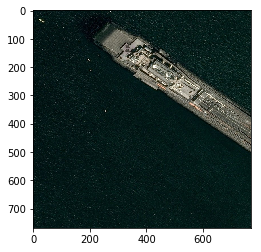

In [17]:
t = train_X[0]
print(t.shape)
imshow(t.squeeze())

(768, 768, 1)


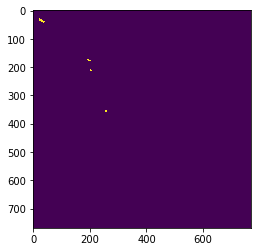

In [18]:
t = train_Y[0]
print(t.shape)
imshow(t.squeeze())

(768, 768, 1)

In [19]:
tf.reset_default_graph()

##### Create input placeholder

In [20]:
#Only the channel size is known
X = tf.placeholder(tf.float32, shape = (None,None,None,config.channels))

In [21]:
Y = tf.placeholder(tf.float32, shape = (None,None,None,1))

##### Create model

In [22]:
def forward_propagation(X):

    
    CONV_1_1 = tf.get_variable("CONV_1_1",[3,3,config.channels,16], initializer = tf.contrib.layers.xavier_initializer());
    CONV_1_2 = tf.get_variable("CONV_1_2",[3,3,16,16], initializer = tf.contrib.layers.xavier_initializer());
     
    CONV_2_1 = tf.get_variable("CONV_2_1",[3,3,16,32], initializer = tf.contrib.layers.xavier_initializer());
    CONV_2_2 = tf.get_variable("CONV_2_2",[3,3,32,32], initializer = tf.contrib.layers.xavier_initializer());
    
    CONV_3_1 = tf.get_variable("CONV_3_1",[3,3,32,64], initializer = tf.contrib.layers.xavier_initializer());
    CONV_3_2 = tf.get_variable("CONV_3_2",[3,3,64,64], initializer = tf.contrib.layers.xavier_initializer());
    
    CONV_4_1 = tf.get_variable("CONV_4_1",[3,3,64,128], initializer = tf.contrib.layers.xavier_initializer());
    CONV_4_2 = tf.get_variable("CONV_4_2",[3,3,128,128], initializer = tf.contrib.layers.xavier_initializer());
    
    CONV_5_1 = tf.get_variable("CONV_5_1",[3,3,128,256], initializer = tf.contrib.layers.xavier_initializer());
    CONV_5_2 = tf.get_variable("CONV_5_2",[3,3,256,256], initializer = tf.contrib.layers.xavier_initializer());
    
    CONV_6_1 = tf.get_variable("CONV_6_1",[2,2,128,256], initializer = tf.contrib.layers.xavier_initializer());
    CONV_6_2 = tf.get_variable("CONV_6_2",[3,3,256,128], initializer = tf.contrib.layers.xavier_initializer());
    CONV_6_3 = tf.get_variable("CONV_6_3",[3,3,128,128], initializer = tf.contrib.layers.xavier_initializer());
    
    CONV_7_1 = tf.get_variable("CONV_7_1",[2,2,64,128], initializer = tf.contrib.layers.xavier_initializer());
    CONV_7_2 = tf.get_variable("CONV_7_2",[3,3,128,64], initializer = tf.contrib.layers.xavier_initializer());
    CONV_7_3 = tf.get_variable("CONV_7_3",[3,3,64,64], initializer = tf.contrib.layers.xavier_initializer());
    
    CONV_8_1 = tf.get_variable("CONV_8_1",[2,2,32,64], initializer = tf.contrib.layers.xavier_initializer());
    CONV_8_2 = tf.get_variable("CONV_8_2",[3,3,64,32], initializer = tf.contrib.layers.xavier_initializer());
    CONV_8_3 = tf.get_variable("CONV_8_3",[3,3,32,32], initializer = tf.contrib.layers.xavier_initializer());
    
    CONV_9_1 = tf.get_variable("CONV_9_1",[2,2,16,32], initializer = tf.contrib.layers.xavier_initializer());
    CONV_9_2 = tf.get_variable("CONV_9_2",[3,3,32,16], initializer = tf.contrib.layers.xavier_initializer());
    CONV_9_3 = tf.get_variable("CONV_9_3",[3,3,16,16], initializer = tf.contrib.layers.xavier_initializer());
    
    CONV_OUT = tf.get_variable("CONV_OUT",[1,1,16,1], initializer = tf.contrib.layers.xavier_initializer());
      
    Z1 = tf.nn.relu(tf.nn.conv2d(X,CONV_1_1, strides=[1,1,1,1], padding='SAME'))
    D1 = tf.nn.dropout(Z1,keep_prob = 0.9)
    V1 = tf.nn.relu(tf.nn.conv2d(D1,CONV_1_2, strides=[1,1,1,1], padding='VALID'))
    A1 = tf.nn.max_pool(V1, ksize = [1, 127, 127, 1], strides = [1,1,1,1], padding = 'VALID')
    
    tf.summary.histogram('A1', A1)
    
    Z2 = tf.nn.relu(tf.nn.conv2d(A1, CONV_2_1, strides=[1,1,1,1], padding='SAME'))
    D2 = tf.nn.dropout(Z2, keep_prob = 0.9)
    V2 = tf.nn.relu(tf.nn.conv2d(D2, CONV_2_2, strides=[1,1,1,1], padding='VALID'))
    A2 = tf.nn.max_pool(V2, ksize = [1, 63, 63, 1], strides = [1,1,1,1], padding = 'VALID')
    
    tf.summary.histogram('A2', A2)
    
    Z3 = tf.nn.relu(tf.nn.conv2d(A2, CONV_3_1, strides=[1,1,1,1], padding='SAME'))
    D3 = tf.nn.dropout(Z3, keep_prob = 0.8)
    V3 = tf.nn.relu(tf.nn.conv2d(D3, CONV_3_2, strides=[1,1,1,1], padding='VALID'))
    A3 = tf.nn.max_pool(V3, ksize = [1, 31, 31, 1], strides = [1,1,1,1], padding = 'VALID')
    
    tf.summary.histogram('A3', A3)
    
    Z4 = tf.nn.relu(tf.nn.conv2d(A3, CONV_4_1, strides=[1,1,1,1], padding='SAME'))
    D4 = tf.nn.dropout(Z4, keep_prob = 0.8)
    V4 = tf.nn.relu(tf.nn.conv2d(D4, CONV_4_2, strides=[1,1,1,1], padding='VALID'))
    A4 = tf.nn.max_pool(V4, ksize = [1, 15, 15, 1], strides = [1,1,1,1], padding = 'VALID')

    tf.summary.histogram('A4', A4)
    #Z5 = tf.nn.relu(tf.nn.conv2d(A4, CONV_5_1, strides=[1,1,1,1], padding='VALID'))
    Z5 = tf.nn.relu(tf.nn.conv2d(A4, CONV_5_1, strides=[1,1,1,1], padding='SAME'))
    D5 = tf.nn.dropout(Z5, keep_prob = 0.8)
    Z5 = tf.nn.relu(tf.nn.conv2d(D5, CONV_5_2, strides=[1,1,1,1], padding='SAME'))
   
    tf.summary.histogram('m_Z5', Z5)

    batch_size = tf.shape(Z5)[0]    
    # top of piramid, or bottom of valley
    Z6 = tf.nn.conv2d_transpose(Z5, CONV_6_1, [batch_size,32,32,128], strides = [1,2,2,1], padding='VALID')
    Z6 = tf.concat([Z6,Z4],3)
    Z6 = tf.nn.relu(tf.nn.conv2d(Z6, CONV_6_2, strides=[1,1,1,1], padding='SAME'))
    D6 = tf.nn.dropout(Z6, keep_prob = 0.8)
    Z6 = tf.nn.relu(tf.nn.conv2d(D6, CONV_6_3, strides=[1,1,1,1], padding='SAME'))
    
    tf.summary.histogram('deconv-Z6', Z6)
    
    Z7 = tf.nn.conv2d_transpose(Z6, CONV_7_1, [batch_size,64,64,64], strides = [1,2,2,1], padding='VALID')
    Z7 = tf.concat([Z7,Z3],3)
    Z7 = tf.nn.relu(tf.nn.conv2d(Z7, CONV_7_2, strides=[1,1,1,1], padding='SAME'))
    D7 = tf.nn.dropout(Z7, keep_prob = 0.8)
    Z7 = tf.nn.relu(tf.nn.conv2d(D7, CONV_7_3, strides=[1,1,1,1], padding='SAME'))
    
    tf.summary.histogram('deconv_Z7', Z7)
    
    Z8 = tf.nn.conv2d_transpose(Z7, CONV_8_1, [batch_size,128,128,32], strides = [1,2,2,1], padding='VALID')
    Z8 = tf.concat([Z8,Z2],3)
    Z8 = tf.nn.relu(tf.nn.conv2d(Z8, CONV_8_2, strides=[1,1,1,1], padding='SAME'))
    D8 = tf.nn.dropout(Z8, keep_prob = 0.9)
    Z8 = tf.nn.relu(tf.nn.conv2d(D8, CONV_8_3, strides=[1,1,1,1], padding='SAME'))
    
    tf.summary.histogram('deconv_Z8', Z8)
    
    Z9 = tf.nn.conv2d_transpose(Z8, CONV_9_1, [batch_size,256,256,16], strides = [1,2,2,1], padding='VALID')
    Z9 = tf.concat([Z9,Z1],3)
    Z9 = tf.nn.relu(tf.nn.conv2d(Z9, CONV_9_2, strides=[1,1,1,1], padding='SAME'))
    D9 = tf.nn.dropout(Z9, keep_prob = 0.9)
    Z9 = tf.nn.relu(tf.nn.conv2d(D9, CONV_9_3, strides=[1,1,1,1], padding='SAME'))
    
    tf.summary.histogram('deconv_Z6', Z9)
    
    output = tf.nn.sigmoid(tf.nn.conv2d(Z9, CONV_OUT, strides=[1,1,1,1], padding='SAME'))
    tf.summary.histogram('activations', output)
    
    return output

In [23]:
def group_list(data_list, group_size):
    """
    Yields groups from l sized group_size
    Args:
        data_list: list
        group_size: size of group
    
    Returns
    yield
    """
    for i in range(0, len(data_list), group_size):
        yield data_list[i:i+group_size]

In [24]:
predictions = forward_propagation(X)

In [25]:
loss = tf.keras.losses.binary_crossentropy(Y,predictions)
cost = tf.reduce_mean(loss)
tf.summary.scalar('cost', cost)

<tf.Tensor 'cost:0' shape=() dtype=string>

##### Intersection over union score

In [26]:
prediction_mask = tf.to_int64(predictions > 0.5)
iou_score, update_op = tf.metrics.mean_iou(Y, prediction_mask, 2)
with tf.control_dependencies([update_op]):
    iou_score = tf.identity(iou_score)
tf.summary.scalar('intersection_overunion', iou_score)

<tf.Tensor 'intersection_overunion:0' shape=() dtype=string>

##### Stats

In [27]:
merged_summary = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('train')
test_writer = tf.summary.FileWriter('test')

In [28]:
def model(train_X, train_Y, test_X, test_Y, epochs, batch_size = 50, learning_rate = 0.005, save = -1, restore= -1):    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    saver = tf.train.Saver()
    sess = tf.Session();
    if(True):
        if(restore!=-1):        
            saver.restore(sess,"saved_model/model_" + str(restore))
        else:
            sess.run(init);
            sess.run(init_l)
            
        
        for epoch in range(epochs):
            start_time = time.time()
            train_X_batches = group_list(train_X,batch_size)
            train_Y_batches = group_list(train_Y,batch_size)
            t_number_of_batches = len(train_X) // batch_size
            
            avg_cost_value = 0.
            
            avg_iou = 0.
            
            for index in range(0,t_number_of_batches):                
                train_row_X = next(train_X_batches)
                
                train_row_Y = next(train_Y_batches)
                
                summary,opt, cost_value, iou_score_training = sess.run([merged_summary,optimizer, cost, iou_score],feed_dict={X: train_row_X, Y: train_row_Y})
                train_writer.add_summary(summary, epoch)
                avg_cost_value += cost_value / t_number_of_batches
                avg_iou += iou_score_training / t_number_of_batches
                
            summary,test_cost_value, t_iou_score = sess.run([merged_summary,cost,iou_score],feed_dict={X: test_X, Y: test_Y})
            duration = time.time() - start_time
            test_writer.add_summary(summary, epoch)
            print("Epoch " '%03d' % (epoch+1), 
                  ": training cost = ", avg_cost_value,
                  " IOU score =  ", avg_iou ,
                  " test cost = ", test_cost_value,
                  " IOU score", t_iou_score,
                  " : in ", duration, "s")
                    
        return sess

In [36]:
#print (train_X[3:,:,:,:])
print (train_Y[5:])

[array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]]), array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False]

In [39]:
sess = model(train_X[:(samples - 1),:,:,:],
             train_Y[:(samples - 1)],
             train_X[(samples - 1):,:,:,:],
             train_Y[(samples - 1):],
             epochs = 1, batch_size = 10)

InvalidArgumentError: Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 528, computed = 16 spatial_dim: 1 input: 32 filter: 2 output: 528 stride: 2 dilation: 1
	 [[{{node conv2d_transpose}} = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv2d_transpose/output_shape, CONV_6_1/read, Relu_9)]]

Caused by op 'conv2d_transpose', defined at:
  File "/home/jun_inthebay/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/jun_inthebay/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/jun_inthebay/anaconda3/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/home/jun_inthebay/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jun_inthebay/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-0434c1cc4abf>", line 1, in <module>
    predictions = forward_propagation(X)
  File "<ipython-input-22-f2e3faad8f21>", line 73, in forward_propagation
    Z6 = tf.nn.conv2d_transpose(Z5, CONV_6_1, [batch_size,32,32,128], strides = [1,2,2,1], padding='VALID')
  File "/home/jun_inthebay/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1255, in conv2d_transpose
    name=name)
  File "/home/jun_inthebay/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1229, in conv2d_backprop_input
    dilations=dilations, name=name)
  File "/home/jun_inthebay/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jun_inthebay/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/jun_inthebay/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/home/jun_inthebay/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 528, computed = 16 spatial_dim: 1 input: 32 filter: 2 output: 528 stride: 2 dilation: 1
	 [[{{node conv2d_transpose}} = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv2d_transpose/output_shape, CONV_6_1/read, Relu_9)]]


In [ ]:
pred_Y = sess.run([predictions],feed_dict={X: pred_X})

In [ ]:
f, arr = plt.subplots(3,2)
arr[0][0].imshow(pred_X[0])
arr[0][1].imshow(Util.convert_to_binary_image(pred_Y[0][1]).squeeze())
arr[1][0].imshow(pred_X[1])
arr[1][1].imshow(Util.convert_to_binary_image(pred_Y[0][2]).squeeze())
arr[2][0].imshow(pred_X[2])
arr[2][1].imshow(Util.convert_to_binary_image(pred_Y[0][3]).squeeze())

## pred_Y

In [ ]:
example = pred_Y[0][3]

In [ ]:
example.shape